In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
experiment = "experiment_trafficlights"

### Reading input data

In [45]:
with open(f'traffic/input_files/{experiment}/traffic.json', "r") as read_file:
    drivers_input_data = json.load(read_file)
with open(f'traffic/input_files/{experiment}/drivers.json', "r") as read_file:
    traffic_input_data = json.load(read_file)
with open(f'traffic/input_files/{experiment}/lights.json', "r") as read_file:
    lights_input_data = json.load(read_file)

### Reading output data

In [98]:
agent_data = pd.read_csv(f'traffic/output_files/{experiment}/agent_data.csv')
agent_data["Velocity"] = agent_data["Velocity"].apply(lambda x: float(x.split(" ")[0].replace("[","")))
agent_data["Velocity"] = agent_data["Velocity"].astype(float)
agent_data.head()

,Step,AgentID,X,Y,Velocity,Current_lane,Is_alive
0,1,0,0.202984,33.333333,0.752157,0,True
1,1,1,0.244856,100.000000,0.401942,1,True
2,1,2,0.000000,100.000000,0.455000,1,False
3,1,3,0.000000,33.333333,0.464627,0,False
4,1,4,0.206633,166.666667,0.430563,2,True


## Flow rate

#### Flow rate: The flow rate is the number of cars that pass a certain point per unit of time.

In [47]:
nodes = []
for node in lights_input_data:
    nodes.append(node["pos"])
print("The x positions of nodes:")
print(nodes)

The x positions of nodes:
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [50]:
t_start = 851
t_end = 5589
measure_point_x = 500
accepted_dist_delta = 10

# A function to calculate flow_rates easy
def calc_flow_rate(t_start,t_end,measure_point_x,accepted_delta):
    return agent_data[(agent_data["Is_alive"]==True)&(agent_data["Step"]>t_start)&(agent_data["Step"]<t_end)&(abs(agent_data["X"]-measure_point_x)<accepted_dist_delta)].drop_duplicates("AgentID").shape[0]


fr = calc_flow_rate( t_start = t_start,
                t_end = t_end,
                measure_point_x = measure_point_x,
                accepted_delta = accepted_dist_delta)

print("flow rate = ",fr)
print(f"Between {t_start} and {t_end} timestamps, there was {fr} cars at point {measure_point_x} with rounding to {accepted_dist_delta}")


flow rate =  50
Between 851 and 5589 timestamps, there was 50 cars at point 500 with rounding to 10


In [88]:
## Rolling average 

def flow_rate_running_avg(t_start, t_end, measure_point_x, accepted_dist_delta, window_size,running_step=100):
    flow_rates = []
    for t in range(t_start, t_end + 1-window_size,running_step):
        flow_rates.append(calc_flow_rate(t, t + window_size, measure_point_x, accepted_dist_delta)) # there was error so i changed flow_rate to calc_flow_rate
    running_avg = sum(flow_rates) / len(flow_rates)
#print(flow_rates) # check it out, A.
    return running_avg

flow_rate_running_avg(851,5589,500,1000,1000)

11.526315789473685

## Density
#### Density: Traffic density is the number of cars per unit length of the road at any instant. 

In [52]:
x_start = 500
x_end = 600
time = 2000
def calc_density(x_start,x_end,time):
    return agent_data[(agent_data["Is_alive"]==True)&(agent_data["X"]>x_start)&(agent_data["X"]<x_end)&(agent_data["Step"]==time)].drop_duplicates("AgentID").shape[0]/(x_end-x_start)
d = calc_density(x_start,x_end,time)

# density at time 2000 between  two given nodes (their x_positions)
print(f"The number of cars between pos_x {x_start} and {x_end}, at time {time}, divided by the distance of {x_end-x_start} is equal {d}")

The number of cars between pos_x 500 and 600, at time 2000, divided by the distance of 100 is equal 0.02


In [53]:
# rolling average

def density_running_avg(x_start,x_end,t_start, t_end, running_step=5):
    densities = []
    for t in range(t_start, t_end +1, running_step):
        densities.append(calc_density(x_start,x_end,t))
    running_avg = sum(densities) / len(densities)
    return running_avg

#running average for the same two nodes, using time range, not specific timestamp this time, the result should be simmilar
density_running_avg(500,600,851,5589)

0.025548523206751047

## Velocity

**Velocity: Average velocity of agents between two nodes in some time window**

In [83]:
t_start = 851
t_end = 5589
x_start = 500
x_end = 600


def calc_mean_velocity(agent_data_frame, t_start, t_end, x_start, x_end):
    mean_velocity = np.mean(agent_data.loc[agent_data["Is_alive"]==True 
               & (agent_data['X']>x_start) 
               & (agent_data["X"]<x_end)
               & (agent_data["Step"]>t_start)
               & (agent_data["Step"]>t_end)]["Velocity"])
    return mean_velocity

velocities_per_agent = calc_mean_velocity(agent_data, 851, 5589, 500, 600)
print(velocities_per_agent)

0.5010756774191958


In [81]:
np.mean(agent_data.loc[agent_data["Is_alive"]==True 
               & (agent_data['X']>x_start) 
               & (agent_data["X"]<x_end)
               & (agent_data["Step"]>t_start)
               & (agent_data["Step"]>t_end)]["Velocity"])



0.5010756774191958

### Can I make a running average for velocity? 

## Making a dataframe that collects the parameters and results of experiments we run? 

In [130]:
import pandas as pd

agent_data = pd.read_csv(f'traffic/output_files/{experiment}/agent_data.csv')
agent_data["Velocity"] = agent_data["Velocity"].apply(lambda x: float(x.split(" ")[0].replace("[","")))
agent_data["Velocity"] = agent_data["Velocity"].astype(float)

t_start = 851
t_end = 5589
x_start = 500
x_end = 600
time = 2000
measure_point_x = 500
accepted_dist_delta = 10
running_step = 333
window_size = 1000

#experiment_results = pd.DataFrame(columns=['experiment', 'average_velocity', 'rolling_average_density', 'rolling_average_flow'])

experiment_results = pd.read_csv('experiment_results.csv')

def collect_data(agent_data, t_start, t_end, x_start, x_end, running_step, measure_point_x, accepted_dist_delta, window_size):
    
    data = {
        'experiment': experiment,
        'average_velocity': calc_mean_velocity(agent_data, t_start, t_end, x_start, x_end),
        'rolling_average_density': density_running_avg(x_start, x_end, t_start, t_end, running_step=5),
        'rolling_average_flow': flow_rate_running_avg(t_start, t_end, measure_point_x, accepted_dist_delta, window_size, running_step=100)
    }
     
    experiment_results.loc[len(experiment_results)] = data

# Call collect_data function to update experiment_results
collect_data(agent_data, t_start, t_end, x_start, x_end, running_step, measure_point_x, accepted_dist_delta, window_size)

# Save experiment_results as a CSV file
experiment_results.to_csv('experiment_results.csv', index=False)


In [131]:
experiment_results

,experiment,average_velocity,rolling_average_density,rolling_average_flow
0,experiment_trafficlights,0.562866,0.021118,12.263158
1,experiment_trafficlights,0.473487,0.027141,11.289474
2,experiment_trafficlights,0.537993,0.027511,12.526316
3,experiment_trafficlights,0.686395,0.016920,11.131579
4,experiment_trafficlights,0.656103,0.015654,11.236842
5,experiment_trafficlights,0.409738,0.027395,10.289474
6,experiment_trafficlights,0.384203,0.027215,9.447368
7,experiment_trafficlights,0.417232,0.032141,9.842105


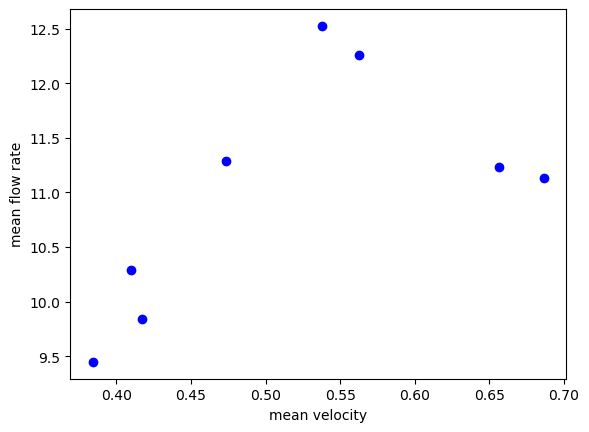

In [132]:
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots()

ax.scatter(experiment_results['average_velocity'], 
           experiment_results['rolling_average_flow'], 
           color='blue')

# Add labels and legend
ax.set_xlabel('mean velocity')
ax.set_ylabel('mean flow rate')
# ax.legend()

# Display the plot
plt.show()

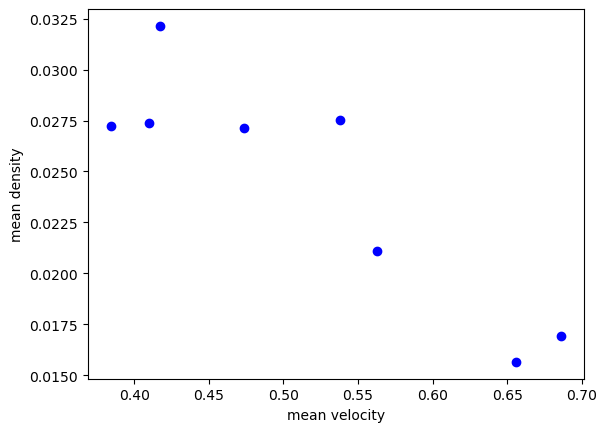

In [133]:
# Create a new figure and axis
fig, ax = plt.subplots()

ax.scatter(experiment_results['average_velocity'], 
           experiment_results['rolling_average_density'], 
           color='blue')

# Add labels and legend
ax.set_xlabel('mean velocity')
ax.set_ylabel('mean density')
# ax.legend()

# Display the plot
plt.show()

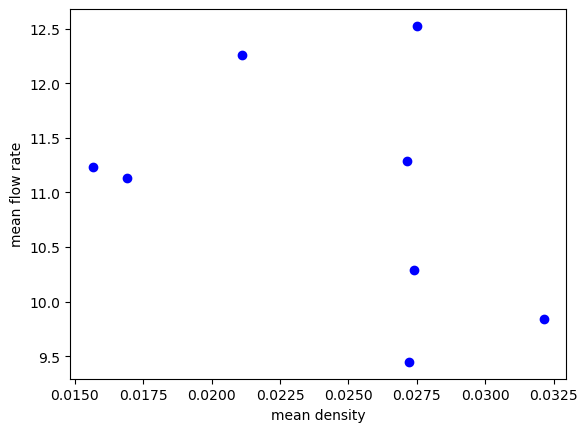

In [134]:
# Create a new figure and axis
fig, ax = plt.subplots()

ax.scatter(experiment_results['rolling_average_density'], 
           experiment_results['rolling_average_flow'], 
           color='blue')

# Add labels and legend
ax.set_xlabel('mean density')
ax.set_ylabel('mean flow rate')
# ax.legend()

# Display the plot
plt.show()